In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tensorboard.backend.event_processing import event_accumulator

In [2]:
import matplotlib.font_manager as font_manager

font_dir = ['.']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

## Our setup results paths

In [3]:
RESULTS_PATH = "../results/panda_slide_long"
LOGS_TEMPLATE_PATH = os.path.join(RESULTS_PATH, "%s", "tb", "TQC_1")

LOG_PATH_LIST = [LOGS_TEMPLATE_PATH % folder for folder in os.listdir(RESULTS_PATH) if os.path.isdir(os.path.join(RESULTS_PATH, folder))]
LOG_PATH_LIST = sorted([os.path.join(log_path, os.listdir(log_path)[0]) for log_path in LOG_PATH_LIST])

In [4]:
results_dict = defaultdict(dict)
all_experiment_combinations = set()
tb_keys = ["eval/success_rate"]
# tb_keys = ["rollout/weight_0", "rollout/weight_1", "rollout/weight_main"]

for filepath in LOG_PATH_LIST:
    config = json.load(open(os.path.join("/".join(filepath.split("/")[:-3]), "config.json"), "r"))
    num_steps = config["train_kwargs"]["total_timesteps"]
    
    run_name = filepath.split("/")[-4]
    baseline_type = run_name.split("_")[4]
    environment = "_".join(run_name.split("_")[-4:-3])
    
    ea = event_accumulator.EventAccumulator(filepath, size_guidance={"scalars": 0})
    ea.Reload()
    
    for tb_key in tb_keys:
        if environment + "-" + tb_key not in results_dict[baseline_type]:
            results_dict[baseline_type][environment + "-" + tb_key] = []

        scalars = [scalar.value for scalar in ea.Scalars(tb_key)]
        scalars = np.interp(np.linspace(0, len(scalars), 100), np.arange(len(scalars)), scalars).tolist()
        
        results_dict[baseline_type][environment + "-" + tb_key].append(scalars)
    
for baseline_type in results_dict.keys():
    for environment in results_dict[baseline_type].keys():
        results_dict[baseline_type][environment] = np.stack(results_dict[baseline_type][environment], axis=0)

## BiPaRS results paths

In [25]:
RESULTS_PATH = "../ipynbs/BiPaRS_partial_results"
LOGS_TEMPLATE_PATH = os.path.join(RESULTS_PATH, "%s", "summary")

BIPARS_LOG_PATH_LIST = [LOGS_TEMPLATE_PATH % folder for folder in os.listdir(RESULTS_PATH) if os.path.isdir(os.path.join(RESULTS_PATH, folder))]
BIPARS_LOG_PATH_LIST = sorted([os.path.join(log_path, tb_log_name) for log_path in BIPARS_LOG_PATH_LIST for tb_log_name in os.listdir(log_path)])

In [26]:
for filepath in BIPARS_LOG_PATH_LIST:
    run_name = filepath.split("/")[-3]
    baseline_type = "BiPaRS_" + "_".join(run_name.split("_")[2:4])
    environment = run_name.split("_")[-1]
    
    if environment not in results_dict[baseline_type]:
        results_dict[baseline_type][environment] = []
    
    ea = event_accumulator.EventAccumulator(filepath, size_guidance={"scalars": 0})
    ea.Reload()
    
    scalars = [scalar.value for scalar in ea.Scalars("Test_Episode_Success")]    
    scalars = np.interp(np.linspace(0, len(scalars), 100), np.arange(len(scalars)), scalars).tolist()
    
    results_dict[baseline_type][environment].append(scalars)
    
for baseline_type in results_dict.keys():
    for environment in results_dict[baseline_type].keys():
        results_dict[baseline_type][environment] = np.stack(results_dict[baseline_type][environment], axis=0)

## Plotting

In [5]:
def filter_recursively(keywords, dictionary):
    if len(keywords) == 0:
        assert not isinstance(dictionary, dict)
        return [""], [dictionary]
    
    experiment_key_list = []
    scalars_list = []
    for dict_key in dictionary.keys():
        if dict_key == keywords[0] or keywords[0] == "*":
            experiment_key, scalars = filter_recursively(keywords[1:], dictionary[dict_key])
            experiment_key = [dict_key + "-" + _experiment_key for _experiment_key in experiment_key]
            
            experiment_key_list += experiment_key
            scalars_list += scalars
            
    return experiment_key_list, scalars_list

In [6]:
import pandas as pd

def rolling_mean(data, window=4):
    result = []
    for row in data:
        result.append(pd.Series(row).rolling(window, min_periods=1, center=True).mean().to_numpy())
    result = np.stack(result, axis=0)
    return result

### Main results plotting

['Times New Roman']


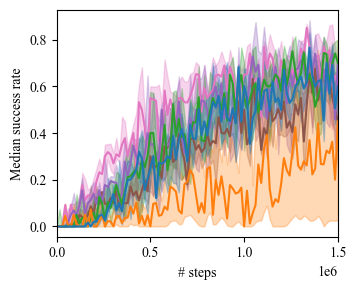

In [8]:
results_to_plot, keys_to_plot = [], []
nrows = 1
keys_map = {
    "random": "Random weights",
    "manualtask": "Main task only",
    "currot": "CurrOT",
    "settersolver": "Setter-Solver",
    "alpgmm": "ALP-GMM",
    "sacx": "SAC-Q",
    "BiPaRS_v1_fop": "BiPaRS-v1",
    "BiPaRS_v2_fsa": "BiPaRS-v2",
    "BiPaRS_v3_fsart": "BiPaRS"
}

ignore = {"BiPaRS_v1_fop", "BiPaRS_v2_fsa"}

algorithm_order = ["manualtask", "random", "sacx", "BiPaRS_v3_fsart", "settersolver", "currot", "alpgmm"]

for key in algorithm_order:
    _keys_to_plot, _results_to_plot = filter_recursively([key, "*"], results_dict)
    _keys_to_plot = np.array(_keys_to_plot)[np.argsort(_keys_to_plot)]
    _results_to_plot = np.array(_results_to_plot, dtype=object)[np.argsort(_keys_to_plot)]
    
    if nrows is None:
        nrows = int(np.ceil(len(_keys_to_plot) / 5))
    
    results_to_plot.append(_results_to_plot)
    keys_to_plot.append(_keys_to_plot)

# print([k, v for k, v in plt.rcParams if k.startswith("font")])
print(plt.rcParams['font.family'])
plt.rcParams['font.family'] = ['Times New Roman']
# plt.rcParams['font.size'] = 12
# plt.rcParams['font.serif'] = 'Times New Roman'
# plt.rcParams['font.sans-serif'] = 'Bitstream Vera Serif'

fig, axes = plt.subplots(nrows, 1, figsize=(5.5 * (2 / 3), 4.5 * (2 / 3)), sharex=True)
axes = np.reshape(axes, -1)

for idx, (keys_to_plot, results_to_plot) in enumerate(zip(keys_to_plot, results_to_plot)):
    for ax, key, result in zip(axes, keys_to_plot, results_to_plot):
        
        if key.split("-")[0] in ignore:
            continue
        
        result = result.astype(float)
        # result = rolling_mean(result, window=10)
        
        ax.plot(np.linspace(0, num_steps, len(result[0])), np.median(result, axis=0), c="C" + str(len(algorithm_order) - idx - 1), label=keys_map[key.split("-")[0]])
        # ax.plot(np.median(result, axis=0), c="C" + str(idx), label=keys_map[key.split("-")[0]])
        if len(result) > 1:
            # ax.fill_between(np.arange(len(result[0])), result.mean(axis=0) - result.std(axis=0), result.mean(axis=0) + result.std(axis=0), alpha=0.4)
            ax.fill_between(np.linspace(0, num_steps, len(result[0])), np.percentile(result, 25, axis=0), np.percentile(result, 75, axis=0), alpha=0.3, color="C" + str(len(algorithm_order) - idx - 1))
        # ax.set_title("-".join(key.split("-")[1:]))
    
    # axes[-1].plot([0], [0], c="C" + str(idx), label=labels[idx])
    # axes[0].legend(loc=10, bbox_to_anchor=(0.5, 1.12), ncol=4, columnspacing=1, handlelength=1, handletextpad=0.5)
    
axes[0].set_xlim(-1, num_steps+1)

axes[0].set_ylabel("Median success rate")
axes[0].set_xlabel("# steps")
plt.tight_layout()
    
plt.savefig(os.path.join(RESULTS_PATH, "mean_reward_small.pdf"))

### Weight plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


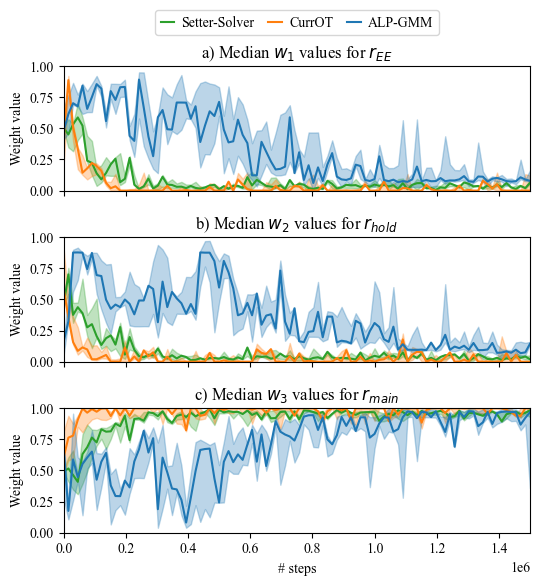

In [31]:
results_to_plot, keys_to_plot = [], []
nrows = 3
keys_map = {
    "random": "Random weights",
    "manualtask": "Main task only",
    "currot": "CurrOT",
    "settersolver": "Setter-Solver",
    "alpgmm": "ALP-GMM",
    "sacx": "SAC-Q",
    "BiPaRS_v1_fop": "BiPaRS-v1",
    "BiPaRS_v2_fsa": "BiPaRS-v2",
    "BiPaRS_v3_fsart": "BiPaRS-v3"
}

ignore = {"random", "manualtask", "sacx"}
algorithm_order = ["manualtask", "random", "sacx", "BiPaRS_v3_fsart", "settersolver", "currot", "alpgmm"]

for key in algorithm_order:
    _keys_to_plot, _results_to_plot = filter_recursively([key, "*"], results_dict)
    _keys_to_plot = np.array(_keys_to_plot)[np.argsort(_keys_to_plot)]
    _results_to_plot = np.array(_results_to_plot, dtype=object)[np.argsort(_keys_to_plot)]
    
    if nrows is None:
        nrows = int(np.ceil(len(_keys_to_plot) / 5))
    
    results_to_plot.append(_results_to_plot)
    keys_to_plot.append(_keys_to_plot)

fig, axes = plt.subplots(nrows, 1, figsize=(5.5, 6), sharex=True)
axes = np.reshape(axes, -1)

for idx, (keys_to_plot, results_to_plot) in enumerate(zip(keys_to_plot, results_to_plot)):
    for ax, key, result in zip(axes, keys_to_plot, results_to_plot):
        if key.split("-")[0] in ignore:
            continue
        
        result = result.astype(float)
        
        ax.plot(np.linspace(0, num_steps, len(result[0])), np.median(result, axis=0), c="C" + str(len(algorithm_order) - idx - 1), label=keys_map[key.split("-")[0]])
        # ax.plot(np.median(result, axis=0), c="C" + str(idx), label=keys_map[key.split("-")[0]])
        if len(result) > 1:
            # ax.fill_between(np.arange(len(result[0])), result.mean(axis=0) - result.std(axis=0), result.mean(axis=0) + result.std(axis=0), alpha=0.4)
            ax.fill_between(np.linspace(0, num_steps, len(result[0])), np.percentile(result, 25, axis=0), np.percentile(result, 75, axis=0), alpha=0.3, color="C" + str(len(algorithm_order) - idx - 1))
        # ax.set_title("-".join(key.split("-")[1:]))
    
    # axes[-1].plot([0], [0], c="C" + str(idx), label=labels[idx])
    axes[0].legend(loc=10, ncols=3, bbox_to_anchor=(0.5, 1.35), columnspacing=1, handlelength=1, handletextpad=0.5)
    
axes[0].set_xlim(-1, num_steps+1)
axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)

axes[0].set_title("a) Median $w_1$ values for $r_{EE}$")
axes[1].set_title("b) Median $w_2$ values for $r_{hold}$")
axes[2].set_title("c) Median $w_3$ values for $r_{main}$")

axes[0].set_ylabel("Weight value")
axes[1].set_ylabel("Weight value")
axes[2].set_ylabel("Weight value")
axes[2].set_xlabel("# steps")
plt.tight_layout()
    
plt.savefig(os.path.join(RESULTS_PATH, "weights.pdf"))